<a href="https://colab.research.google.com/github/Drime648/seafood-detector/blob/main/fish_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Add Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip gdrive/MyDrive/fish_data.zip

# Process the Data

In [ ]:
train_dir = "/content/fish_data/train_fish/"
test_dir = "/content/fish_data/test_fish/"

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
IMG_SIZE = (224, 224)

train_data  = image_dataset_from_directory(train_dir, image_size=IMG_SIZE, label_mode="categorical", batch_size=32)

test_data = image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE, batch_size=32)

Found 9000 files belonging to 9 classes.
Found 430 files belonging to 9 classes.


In [ ]:
class_names = train_data.class_names

In [ ]:
class_names

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [ ]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 9)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 9)), types: (tf.float32, tf.float32)>)

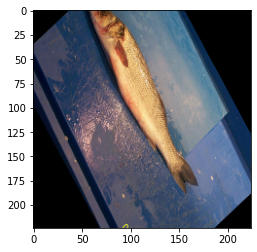

In [ ]:
import matplotlib.pyplot as plt
for images, labels in train_data.take(1):
  # print(images[0] / 255., labels[0])
  plt.imshow(images[0] / 255.)

# callbacks

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.1,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

# Base Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation = "softmax")(x) 

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history_1 = model.fit(train_data,
                    epochs = 20,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.1 * len(test_data)),
                    callbacks = [early_stopping,
                                 reduce_lr])

Epoch 1/20
282/282 [==============================] - 110s 264ms/step - loss: 0.4323 - accuracy: 0.9051 - val_loss: 0.1972 - val_accuracy: 0.9375
Epoch 2/20
282/282 [==============================] - 63s 219ms/step - loss: 0.0771 - accuracy: 0.9917 - val_loss: 0.1356 - val_accuracy: 0.9688
Epoch 3/20
282/282 [==============================] - 61s 211ms/step - loss: 0.0422 - accuracy: 0.9967 - val_loss: 0.1029 - val_accuracy: 0.9375
Epoch 4/20
282/282 [==============================] - 61s 212ms/step - loss: 0.0284 - accuracy: 0.9983 - val_loss: 0.1744 - val_accuracy: 0.9375
Epoch 5/20
282/282 [==============================] - 61s 210ms/step - loss: 0.0211 - accuracy: 0.9989 - val_loss: 0.0755 - val_accuracy: 0.9688
Epoch 6/20
282/282 [==============================] - 61s 211ms/step - loss: 0.0168 - accuracy: 0.9992 - val_loss: 0.1028 - val_accuracy: 0.9375
Epoch 7/20
282/282 [==============================] - 63s 218ms/step - loss: 0.0139 - accuracy: 0.9991 - val_loss: 0.0284 - val_a

In [ ]:
model.evaluate(test_data)

14/14 [==============================] - 8s 313ms/step - loss: 0.0779 - accuracy: 0.9767


[0.07790812104940414, 0.9767441749572754]

In [ ]:
model.save("fish_vision.h5")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
1+1

2